# Quantify interaction between theta and low-gamma

In [593]:
## plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import cmocean

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter, hilbert, chirp
from scipy import stats
from scipy.stats import binned_statistic


## time_frequency
import mne
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test


## pac
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

# Load study related info

In [2]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs             = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

# Util functions for signal processing

In [62]:
def hilbert_transform(tmp_lfp_notch, fs, low_amp_freq,high_amp_freq):

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)

    raw_band = raw.copy()
    raw_band.filter(2, 8, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks)
    raw_phase = raw_hilb.copy()
    raw_phase.apply_function(np.angle, hilb_picks)
    raw_phase = raw_phase.get_data()[0].real

    raw_band = raw.copy()
    raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks)
    raw_amp = raw_hilb.copy()
    raw_amp.apply_function(np.abs, hilb_picks)
    raw_amp = raw_amp.get_data()[0].real

    return raw_phase, raw_amp


def hilbert_transform_get_component(tmp_lfp_notch, fs, low_amp_freq,high_amp_freq, component):
    
    '''
    Transform signal and get either phase or amplitude component
    component: 'phase' or 'amplitude'
    '''

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)
    
    if component == 'phase':

        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.angle, hilb_picks)
        raw_out = raw_out.get_data()[0].real
        
    if component == 'amplitude':


        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.abs, hilb_picks)
        raw_out = raw_out.get_data()[0].real

    return raw_out




def calculate_KB(bs):

    'PAD is the phase amp distribution'
    pad = bs[0]
    pad_2 = np.hstack((pad , pad))

    num_bins = pad_2.size
    n_pevents = float(np.sum(pad_2))
    ppp = -1 * np.sum((pad_2/n_pevents) * np.log((pad_2/n_pevents)))
    K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

    return K_L


# Compute PAC along cue/sec conditions in different frequency bands

In [47]:
var_of_interst = 'kb'

all_mmcs = []
all_mmcs_w = []

freqs_band_start = np.linspace(15,100,10)


for fff in range(freqs_band_start.size-1):
    print(fff, freqs_band_start[fff])


    low_amp_freq = freqs_band_start[fff]
    high_amp_freq = freqs_band_start[fff] + 15  #freqs_band_start[fff+1]


    amp_phase = {}

    ### Run each session
    for sub in range(len(sessions)):

        amp_phase[sub] = {}
        amp_phase[sub]['phase'] = []
        amp_phase[sub]['amp'] = []

        ### Load this session dataset
        lfp = loadmat('../Data/'+sessions[sub]+'.mat')
        lfp = lfp['ourData']


        ### Loop through this session/patient hippocampal channel
        for cc in hpc_electrodes[sub]:

            ### Get this channel LFP 
            tmp_lfp = lfp[cc]         

            tmp_lfp_notch = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )
            raw_phase, raw_amp = hilbert_transform(tmp_lfp_notch, fs, low_amp_freq, high_amp_freq )

            amp_phase[sub]['phase'].append( raw_phase)
            amp_phase[sub]['amp'].append( raw_amp)




    trial_begin           = 500
    trial_end             = 3500#4000
    # trial_begin           = 0
    # trial_end             = 1500


    ## Trial type
    tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
    tmp_speed = np.tile( np.arange(3), 9 )
    tmp_dur = [ 18.1, 13.5, 11]
    tmp_dd = [50,100,150]


    log_pac = []
    for sub in range(len(sessions)):

        idx_trials = trials_markers[sessions[sub]]


        for cc in range(len(amp_phase[sub]['amp'])):

            tmp_amp = amp_phase[sub]['amp'][cc]
            tmp_phase = amp_phase[sub]['phase'][cc]


            for trial in range(len(idx_trials)):

                tmp_tmp_amp = tmp_amp[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
                tmp_tmp_phase = tmp_phase[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]

                bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp)
                kb = calculate_KB(bs)

                cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
                csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))
                log_pac.append( [sub, tmp_density[trial], tmp_speed[trial], cs, csw, kb] )


    log_pac = pd.DataFrame(log_pac, columns=['sub','density','speed','cuesec','cuesec_w','kb'] )

    mmcs = log_pac.groupby(['cuesec']).median()[var_of_interst]
    mmcs_w = log_pac.groupby(['cuesec_w']).median()[var_of_interst]
    
    
    cw_lm=ols('cuesec ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical    
    pppvv = sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb']
    cw_lm=ols('cuesec_w ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical    
    pppvv_w = sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb']

    
    all_mmcs.append([mmcs,pppvv])
    all_mmcs_w.append([mmcs_w,pppvv_w])

0 15.0
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 15 - 30 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 15 - 30 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
R

Setting up band-pass filter from 15 - 30 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 15 - 30 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 15 - 30 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, 

Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 24 - 39 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=215001
    Range : 0 ... 215000 =      0.000 ...   419.922 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 24 - 39 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=215001
    Range : 0 ... 215000 =      0.000 ...   419.922 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 24 - 39 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-s

Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 34 - 49 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 34 - 49 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=204501
    Range : 0 ... 204500 =      0.000 ...   399.414 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 se

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 34 - 49 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=203501
    Range : 0 ... 203500 =      0.000 ...   397.461 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 34 - 49 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=203501
    Range : 0 ... 203500 =      0.000 ...   397.461 secs
Ready.
S

Setting up band-pass filter from 43 - 58 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=215001
    Range : 0 ... 215000 =      0.000 ...   419.922 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 43 - 58 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=215001
    Range : 0 ... 215000 =      0.000 ...   419.922 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 43 - 58 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, 

Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 53 - 68 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=204501
    Range : 0 ... 204500 =      0.000 ...   399.414 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 53 - 68 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=204501
    Range : 0 ... 204500 =      0.000 ...   399.414 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 53 - 68 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-s

    Range : 0 ... 203500 =      0.000 ...   397.461 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 53 - 68 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=203501
    Range : 0 ... 203500 =      0.000 ...   397.461 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 53 - 68 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=203501
    Range : 0 ... 203500 =      0.000 ...   397.461 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 53 - 68 Hz
Filter len

Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 62 - 77 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 62 - 77 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter f

Setting up band-pass filter from 72 - 87 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=204501
    Range : 0 ... 204500 =      0.000 ...   399.414 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 72 - 87 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=220501
    Range : 0 ... 220500 =      0.000 ...   430.664 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 72 - 87 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, 

Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 72 - 87 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=221001
    Range : 0 ... 221000 =      0.000 ...   431.641 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 72 - 87 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=221001
    Range : 0 ... 221000 =      0.000 ...   431.641 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 72 - 87 Hz
Filter length of 845 samples (1.650 sec) selected
7 81.111111111111

    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 81 - 96 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 81 - 96 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 81 - 96 Hz
Filter len

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=220501
    Range : 0 ... 220500 =      0.000 ...   430.664 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 91 - 1.1e+02 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=220501
    Range : 0 ... 220500 =      0.000 ...   430.664 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 91 - 1.1e+02 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=220501
    Range : 0 ... 220500 =      0.000 ...   430.664 sec

Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 91 - 1.1e+02 Hz
Filter length of 845 samples (1.650 sec) selected


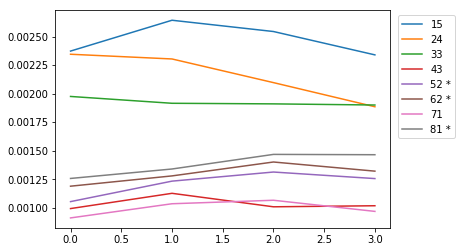

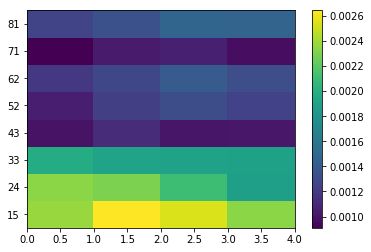

In [61]:

tmp_m = []

for ii in range(len(all_mmcs_w)-1):
    tmp_m.append( all_mmcs_w[ii][0]  )
    
    ll =  str(int(freqs_band_start[ii])) 
    if all_mmcs_w[ii][1] < 0.05: ll+= ' *'     
    
    plt.plot( all_mmcs_w[ii][0], label=ll  )
tmp_m = np.array(tmp_m)


plt.legend( bbox_to_anchor=(1.01,1) )
plt.show()

plt.pcolor(tmp_m)

plt.yticks( np.arange(len(all_mmcs)-1)+0.5, freqs_band_start[:-1].astype(int) )

plt.colorbar()

# Count cycles per trial

In [463]:
trial_begin           = 500
trial_end             = 1500

## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]

ll_f, hh_f = 3,8

count_cycles = []    
for sub in range(len(sessions)):
    idx_trials = trials_markers[sessions[sub]]

    ### Load this session dataset
    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']


    for cc in hpc_electrodes[sub]:

        tmp_lfp = lfp[cc]         

        tmp_lfp = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )

        raw_out = hilbert_transform_get_component(tmp_lfp, fs, ll_f, hh_f, 'phase')

        idx_cycles = np.where( np.abs(np.diff(raw_out)) > 5. )[0]



        for trial in range(len(idx_trials)):
            cycle_counts = np.where( np.logical_and( idx_cycles>idx_trials[trial], idx_cycles<(idx_trials[trial]+trial_end) ) )[0].size
            
#             cycle_counts = cycle_counts / ( trial_end/fs )

            cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
            csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))

            count_cycles.append( [sub, tmp_density[trial], tmp_speed[trial], cs, csw, cycle_counts] )

count_cycles = pd.DataFrame(count_cycles, columns=['sub','density','speed','cuesec','cuesec_w','cycle_counts'] )

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray 

Creating RawArray with float64 data, n_channels=1, n_times=203501
    Range : 0 ... 203500 =      0.000 ...   397.461 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=221001
    Range : 0 ... 221000 =      0.000 ...   431.641 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=221001
    Range : 0 ... 221000 =      0.000 ...   431.641 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected


                  sum_sq     df         F    PR(>F)
cycle_counts    0.645145    1.0  0.724646  0.394876
Residual      719.354855  808.0       NaN       NaN
Pearson:  (0.02993384447287387, 0.39487648246198215)


Text(0.5, 0, 'Cues/sec level')

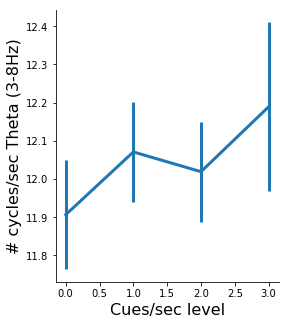

In [258]:

var_of_interst = 'cycle_counts'

mmcs = count_cycles.groupby(['cuesec_w']).mean()[var_of_interst]
sscs = count_cycles.groupby(['cuesec_w']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(5)
fig.set_figwidth(4)
ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )
fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


cw_lm=ols('cuesec_w ~ ' + var_of_interst , data=count_cycles).fit() #Specify C for Categorical    
pppvv = sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)'][var_of_interst]
print(sm.stats.anova_lm(cw_lm, typ=2))
print( 'Pearson: ',  stats.pearsonr(count_cycles.cuesec_w, count_cycles[var_of_interst] ))


plt.sca(ax)

plt.ylabel('# cycles/sec Theta ('+str(ll_f)+'-'+str(hh_f)+'Hz)', fontsize=16)
# plt.ylabel('# cycles/sec Gamma (28-47Hz)', fontsize=16)

plt.xlabel('Cues/sec level', fontsize=16)


# Count gamma amplitude 

In [267]:
trial_begin           = 500
trial_end             = 1500

## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]


ll_f, hh_f = 40,85

mean_amp = []    
for sub in range(len(sessions)):
    idx_trials = trials_markers[sessions[sub]]

    ### Load this session dataset
    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']


    for cc in hpc_electrodes[sub]:

        tmp_lfp = lfp[cc]         


        raw_out = hilbert_transform_get_component(tmp_lfp, fs, ll_f, hh_f, 'amplitude')

#         idx_cycles = np.where( np.abs(np.diff(raw_out)) > 5. )[0]

        
        for trial in range(len(idx_trials)):
            
#             cycle_counts = np.where( np.logical_and( idx_cycles>idx_trials[trial], idx_cycles<idx_trials[trial]+trial_end ) )[0].size            
#             cycle_counts = cycle_counts / ( trial_end/fs )

            mean_amp_trial = np.mean(raw_out[ idx_trials[trial] : idx_trials[trial]+trial_end  ])

            cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
            csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))

            mean_amp.append( [sub, tmp_density[trial], tmp_speed[trial], cs, csw, mean_amp_trial] )

mean_amp = pd.DataFrame(mean_amp, columns=['sub','density','speed','cuesec','cuesec_w','mean_amp'] )

Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 40 - 85 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 40 - 85 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 40 - 85 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 40 - 85 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=204501
    Range : 0 ... 204500 =      0.000 

              sum_sq     df         F    PR(>F)
mean_amp    0.587092    1.0  0.659385  0.417016
Residual  719.412908  808.0       NaN       NaN
Pearson:  (-0.028555309143224645, 0.4170161435405858)


Text(0.5, 0, 'Cues/sec level')

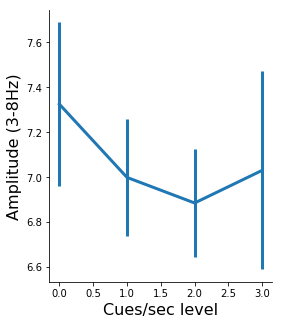

In [266]:

var_of_interst = 'mean_amp'

mmcs = mean_amp.groupby(['cuesec_w']).mean()[var_of_interst]
sscs = mean_amp.groupby(['cuesec_w']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(5)
fig.set_figwidth(4)
ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )
fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


cw_lm=ols('cuesec_w ~ ' + var_of_interst , data=mean_amp).fit() #Specify C for Categorical    
pppvv = sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)'][var_of_interst]
print(sm.stats.anova_lm(cw_lm, typ=2))
print( 'Pearson: ',  stats.pearsonr(mean_amp.cuesec_w, mean_amp[var_of_interst] ))


plt.sca(ax)
plt.ylabel('Amplitude ('+str(ll_f)+'-'+str(hh_f)+'Hz)', fontsize=16)
plt.xlabel('Cues/sec level', fontsize=16)


In [177]:
mean_amp.head()

,sub,density,speed,cuesec,cuesec_w,mean_amp
0,0,0,0,2.762431,0,16.272287
1,0,0,1,3.703704,0,6.949354
2,0,0,2,4.545455,1,6.206635
3,0,1,0,5.524862,1,6.467396
4,0,1,1,7.407407,1,4.794958


In [247]:
tg_ratio = count_cycles.to_numpy()[:,5] / mean_amp.to_numpy()[:,5]

In [248]:
mean_amp['tg_ratio'] = tg_ratio

              sum_sq     df         F    PR(>F)
tg_ratio    0.162138    1.0  0.181996  0.669777
Residual  719.837862  808.0       NaN       NaN
Pearson:  (0.015006376647432148, 0.6697774807159285)


Text(0.5, 0, 'Cues/sec level')

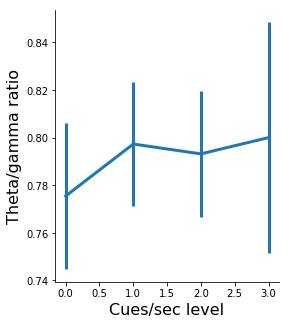

In [249]:

var_of_interst = 'tg_ratio'

mmcs = mean_amp.groupby(['cuesec_w']).mean()[var_of_interst]
sscs = mean_amp.groupby(['cuesec_w']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(5)
fig.set_figwidth(4)
ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )
fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


cw_lm=ols('cuesec_w ~ ' + var_of_interst , data=mean_amp).fit() #Specify C for Categorical    
pppvv = sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)'][var_of_interst]
print(sm.stats.anova_lm(cw_lm, typ=2))
print( 'Pearson: ',  stats.pearsonr(mean_amp.cuesec_w, mean_amp[var_of_interst] ))


plt.sca(ax)

plt.ylabel('Theta/gamma ratio', fontsize=16)
plt.xlabel('Cues/sec level', fontsize=16)


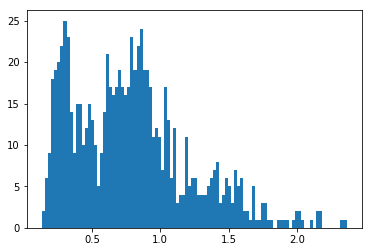

In [250]:
plt.hist(  count_cycles.to_numpy()[:,5] / mean_amp.to_numpy()[:,5], bins=100 );

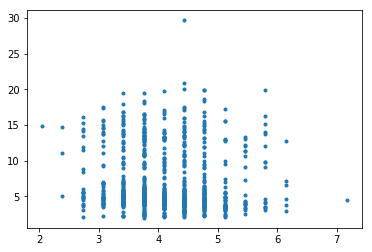

In [251]:
plt.plot(  count_cycles.to_numpy()[:,5] , mean_amp.to_numpy()[:,5], '.' );

In [268]:
# plt.plot( count_cycles.to_numpy()[:,5], '.' )

count_cycles_np = count_cycles.to_numpy()
mean_amp_np     = mean_amp.to_numpy()


In [292]:
tmp = []
for sub in range(8):
    
    tmp_tmp = [] 
    for cuesec in range(4):
        
        
        idx = np.where(  np.logical_and( count_cycles_np[:,0]==sub, count_cycles_np[:,4]==cuesec )   )
        
        
        mmmm1 = np.mean(stats.zscore(count_cycles_np[idx,5]))
        mmmm2 = np.mean(stats.zscore(mean_amp_np[idx,5]))
        
        
        
        tmp_tmp.append( [ mmmm1,mmmm2 ] )
        
    tmp.append(tmp_tmp)
    
tmp = np.array(tmp)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


<ErrorbarContainer object of 3 artists>

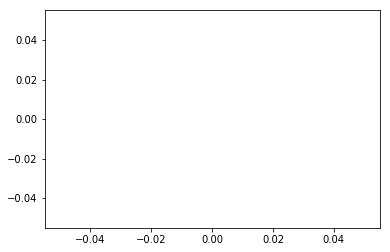

In [293]:
mm = np.mean(tmp[:, :, 0],axis=0) 
ss = stats.sem(tmp[:, :, 0],axis=0) 

plt.errorbar( range(mm.size), mm, yerr=ss )

<ErrorbarContainer object of 3 artists>

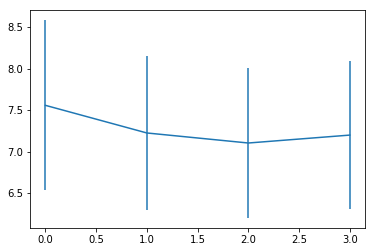

In [286]:
mm = np.mean(tmp[:, :, 1],axis=0) 
ss = stats.sem(tmp[:, :, 1],axis=0) 

plt.errorbar( range(mm.size), mm, yerr=ss )

<ErrorbarContainer object of 3 artists>

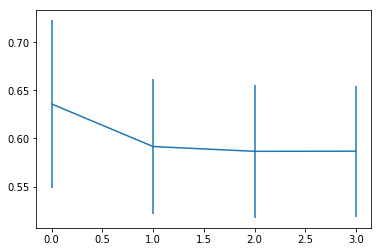

In [290]:
mm = np.mean(tmp[:, :, 1]/tmp[:, :, 0],axis=0) 
ss = stats.sem(tmp[:, :, 1]/tmp[:, :, 0],axis=0) 

plt.errorbar( range(mm.size), mm, yerr=ss )

# Theta cycle dependent gamma amplitude

In [316]:
trial_begin           = 500
trial_end             = 1500

## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]

ll_f_theta, hh_f_theta = 3,8
ll_f_gamma, hh_f_gamma = 40,80

amp_in_cycle = []    
for sub in range(len(sessions)):
    idx_trials = trials_markers[sessions[sub]]

    ### Load this session dataset
    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']


    for cc in hpc_electrodes[sub]:

        tmp_lfp = lfp[cc]         


        raw_out_theta = hilbert_transform_get_component(tmp_lfp, fs, ll_f_theta, hh_f_theta, 'phase')
        raw_out_gama  = hilbert_transform_get_component(tmp_lfp, fs, ll_f_gamma, hh_f_gamma, 'amplitude')


        for trial in range(len(idx_trials)):
            idx = np.where(  raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  < 0 )[0]   
            
            mean_amp_in_cycle = np.mean(raw_out_gama[idx_trials[trial]:idx_trials[trial]+trial_end][idx])
            
            

            cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
            csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))

            amp_in_cycle.append( [sub, tmp_density[trial], tmp_speed[trial], cs, csw, mean_amp_in_cycle] )

amp_in_cycle = pd.DataFrame(amp_in_cycle, columns=['sub','density','speed','cuesec','cuesec_w','mean_amp_in_cycle'] )

Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 40 - 80 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 40 - 80 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ... 

Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 40 - 80 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 40 - 80 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times

In [317]:
amp_in_cycle.head()

,sub,density,speed,cuesec,cuesec_w,mean_amp_in_cycle
0,0,0,0,2.762431,0,16.553932
1,0,0,1,3.703704,0,7.061245
2,0,0,2,4.545455,1,6.390820
3,0,1,0,5.524862,1,6.658781
4,0,1,1,7.407407,1,5.214817


                       sum_sq     df         F    PR(>F)
mean_amp_in_cycle    0.513618    1.0  0.576805  0.447789
Residual           719.486382  808.0       NaN       NaN
Pearson:  (-0.026708771203609608, 0.44778886404207885)


Text(0.5, 0, 'Cues/sec level')

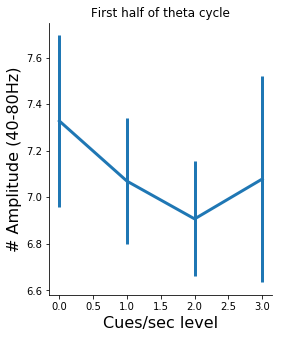

In [318]:

var_of_interst = 'mean_amp_in_cycle'

mmcs = amp_in_cycle.groupby(['cuesec_w']).mean()[var_of_interst]
sscs = amp_in_cycle.groupby(['cuesec_w']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(5)
fig.set_figwidth(4)
ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )
fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


cw_lm=ols('cuesec_w ~ ' + var_of_interst , data=amp_in_cycle).fit() #Specify C for Categorical    
pppvv = sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)'][var_of_interst]
print(sm.stats.anova_lm(cw_lm, typ=2))
print( 'Pearson: ',  stats.pearsonr(amp_in_cycle.cuesec_w, amp_in_cycle[var_of_interst] ))

plt.title("First half of theta cycle")
plt.sca(ax)

plt.ylabel('# Amplitude ('+str(ll_f_gamma)+'-'+str(hh_f_gamma)+'Hz)', fontsize=16)
# plt.ylabel('# cycles/sec Gamma (28-47Hz)', fontsize=16)

plt.xlabel('Cues/sec level', fontsize=16)



In [716]:
trial_begin           = 0
trial_end             = 1500

## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]

ll_f_theta, hh_f_theta = 3,8
ll_f_gamma, hh_f_gamma = 30,89


for hcycle in range(2):


    amp_in_cycle = []    
    for sub in range(len(sessions)):
        idx_trials = trials_markers[sessions[sub]]

        ### Load this session dataset
        lfp = loadmat('../Data/'+sessions[sub]+'.mat')
        lfp = lfp['ourData']


        for cc in hpc_electrodes[sub]:

            tmp_lfp = lfp[cc]

            tmp_lfp = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )

            raw_out_theta = hilbert_transform_get_component(tmp_lfp, fs, ll_f_theta, hh_f_theta, 'phase')
            raw_out_gama  = hilbert_transform_get_component(tmp_lfp, fs, ll_f_gamma, hh_f_gamma, 'amplitude')

            for trial in range(len(idx_trials)):


                if hcycle == 0:
                    idx = np.where( raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  > 0 )[0]
#                     idx = np.where( np.logical_and( raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  > (-np.pi/2) ,
#                                                     raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  < (np.pi/2) ) )[0]

                
                if hcycle == 1:
                    idx = np.where( raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  < 0 )[0]
#                     idx = np.where( np.logical_or( raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  < (-np.pi/2) ,
#                                                    raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  > (np.pi/2) ) )[0]



                mean_amp_in_cycle = np.mean(raw_out_gama[idx])

                amp_in_cycle.append( [sub, mean_amp_in_cycle] )

    amp_in_cycle = pd.DataFrame(amp_in_cycle, columns=['sub','mean_amp_in_cycle'] )
    
    if hcycle == 0: amp_in_cycle_np_1 = amp_in_cycle.to_numpy()
    if hcycle == 1: amp_in_cycle_np_2 = amp_in_cycle.to_numpy()

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 30 - 89 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 30 - 89 Hz


    Range : 0 ... 215000 =      0.000 ...   419.922 secs
Ready.
Setting up band-pass filter from 30 - 89 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 30 - 89 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArra

Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 30 - 89 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 30 - 89 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Ran

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 30 - 89 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 3 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   400.391 secs
Ready.
Setting up band-pass filter from 30 - 89 Hz


(0.94, 1.06)

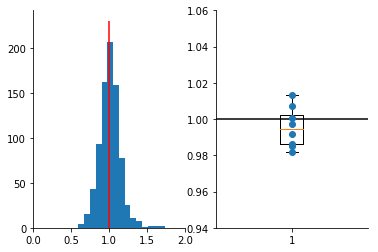

In [701]:
fig = plt.figure()
# fig.set_figheight(4)
# fig.set_figwidth(4)
fig.patch.set_facecolor('xkcd:white')



ax = fig.add_subplot(121)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.hist( amp_first/amp_second, cumulative=False, bins=15);
plt.xlim(0,2)
plt.vlines(1,0,230,'r')


ax = fig.add_subplot(122)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
rat = amp_in_cycle_np_1[:,1] / amp_in_cycle_np_2[:,1]
av_rat =[    np.mean(rat[np.where( amp_in_cycle_np_1[:,0] == sub )[0]]) for sub in range(8)]

plt.boxplot(av_rat);
plt.plot(  np.ones(len(av_rat)), av_rat, 'o' )
plt.hlines(1,0,2)
plt.ylim(1-.06,1+.06)

(0.94, 1.06)

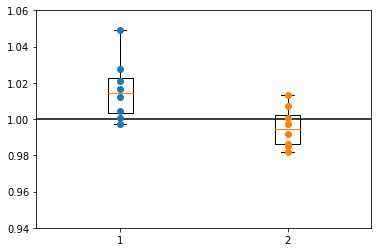

In [706]:
# av_rat_up_low =  np.copy(av_rat)
# av_rat_half_cycles =  np.copy(av_rat)

plt.boxplot([av_rat_half_cycles,av_rat_up_low]);

plt.plot(  np.ones(len(av_rat_half_cycles)), av_rat_half_cycles, 'o' )
plt.plot(  np.ones(len(av_rat_up_low))+1, av_rat_up_low, 'o' )
plt.hlines(1,0.5,2.5)
plt.ylim(1-.06,1+.06)

([<matplotlib.axis.XTick at 0x140d5c588>,
 <a list of 2 Text xticklabel objects>)

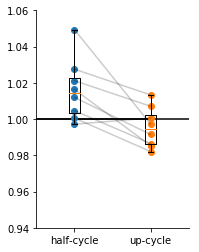

In [728]:
fig = plt.figure()
# fig.set_figheight(4)
# fig.set_figwidth(4)
fig.patch.set_facecolor('xkcd:white')



ax = fig.add_subplot(121)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.hist( amp_first/amp_second, cumulative=False, bins=15);
# plt.xlim(0,2)
# plt.vlines(1,0,230,'r')


# ax = fig.add_subplot(122)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
rat = amp_in_cycle_np_1[:,1] / amp_in_cycle_np_2[:,1]
av_rat =[    np.mean(rat[np.where( amp_in_cycle_np_1[:,0] == sub )[0]]) for sub in range(8)]

plt.plot(  np.ones(len(av_rat_half_cycles)), av_rat_half_cycles, 'o' )
plt.plot(  np.ones(len(av_rat_up_low))+1, av_rat_up_low, 'o' )

plt.plot( [1,2],[av_rat_half_cycles,av_rat_up_low], 'k', alpha=0.2 )


plt.boxplot([av_rat_half_cycles,av_rat_up_low]);
plt.hlines(1,0.5,2.5)
plt.ylim(1-.06,1+.06)

plt.hlines(1,0,2)
plt.ylim(1-.06,1+.06)

plt.xticks([1,2],['half-cycle', 'up-cycle'])

In [711]:
print( stats.ttest_ind(np.ones(len(av_rat_half_cycles)), av_rat_half_cycles)[1], stats.ttest_1samp( av_rat_half_cycles, 1.)[1])
print( stats.ttest_ind(np.ones(len(av_rat_up_low)), av_rat_up_low)[1], stats.ttest_1samp( av_rat_up_low, 1.)[1])
print( stats.ttest_ind(av_rat_half_cycles, av_rat_up_low)[1] )


0.01777021803399057 0.031310819307744785
0.2665868246481314 0.2851801153525254
0.012098958019728564


In [687]:
stats.ttest_ind(np.ones(len(av_rat)), av_rat), stats.ttest_1samp( av_rat, 1.)

(Ttest_indResult(statistic=1.1571166607504757, pvalue=0.2665868246481314),
 Ttest_1sampResult(statistic=-1.1571166607504757, pvalue=0.2851801153525254))

<ErrorbarContainer object of 3 artists>

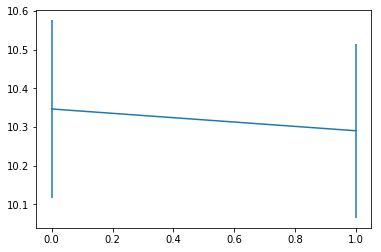

In [720]:
mm1 = np.mean(amp_in_cycle_np_1[:,1] )
ss1 = stats.sem(amp_in_cycle_np_1[:,1] )

mm2 = np.mean(amp_in_cycle_np_2[:,1] )
ss2 = stats.sem(amp_in_cycle_np_2[:,1] )


plt.errorbar(range(2), [mm1,mm2], yerr=[ss1,ss2])

In [721]:
for sub in range(8):    
    idx = np.where( amp_in_cycle_np_1[:,0] == sub )[0]    
    print(stats.ttest_ind(  amp_in_cycle_np_1[idx,1]/amp_in_cycle_np_2[idx,1] , np.ones(idx.size) ))

Ttest_indResult(statistic=0.35464605924281395, pvalue=0.7232040020550936)
Ttest_indResult(statistic=1.7191305658151352, pvalue=0.08703660742760509)
Ttest_indResult(statistic=1.1013753608758334, pvalue=0.2719705444864032)
Ttest_indResult(statistic=0.05062133630414118, pvalue=0.9596744778025494)
Ttest_indResult(statistic=1.713004018696677, pvalue=0.0881600940238023)
Ttest_indResult(statistic=0.8783680791335703, pvalue=0.3807291334344961)
Ttest_indResult(statistic=-0.21795644456424557, pvalue=0.8276707362429835)
Ttest_indResult(statistic=1.1529143386357896, pvalue=0.2515388065212027)


(1500, 1, 2)
(1499, 2, 2)


Text(0.5, 0, 'Time (sec)')

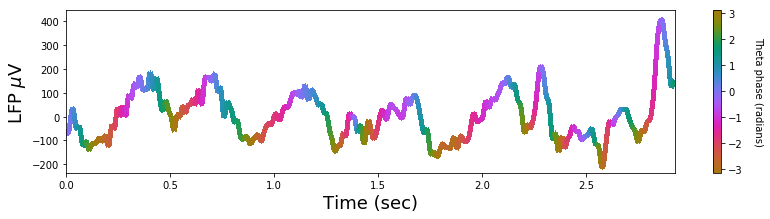

In [631]:
sss,eee = 4300,5800


x = np.linspace(  0 , sizee/fs, sizee      )
y = tmp_lfp[sss:eee]
t = raw_out_theta[sss:eee]




# set up a list of (x,y) points
points = np.array([x,y]).transpose().reshape(-1,1,2)
print( points.shape)  # Out: (len(x),1,2)

# set up a list of segments
segs = np.concatenate([points[:-1],points[1:]],axis=1)
print( segs.shape)  # Out: ( len(x)-1, 2, 2 )
                  # see what we've done here -- we've mapped our (x,y)
                  # points to an array of segment start/end coordinates.
                  # segs[i,0,:] == segs[i-1,1,:]

# make the collection of segments
lc = LineCollection(segs, cmap=cmocean.cm.phase, linewidth=4, antialiaseds=False)
lc.set_array(t) # color the segments by our parameter

# plot the collection
fig = plt.figure(figsize=(30,3))
ax = fig.add_subplot(121)

plt.gca().add_collection(lc) # add the collection to the plot
plt.xlim(x.min(), x.max()) # line collections don't auto-scale the plot
plt.ylim(y.min()*1.1, y.max()*1.1)
cbar = fig.colorbar(lc)
cbar.set_label('Theta phase (radians)', rotation=270, labelpad=20)

fig.set_facecolor('xkcd:white')


plt.ylabel(r'LFP $\mu$V', fontsize=18)
plt.xlabel('Time (sec)', fontsize=18)


(array([130., 152., 149., 136., 149., 183., 172., 126., 160., 143.]),
 array([-3.14084291e+00, -2.51314502e+00, -1.88544712e+00, -1.25774922e+00,
        -6.30051327e-01, -2.35342979e-03,  6.25344467e-01,  1.25304236e+00,
         1.88074026e+00,  2.50843816e+00,  3.13613605e+00]),
 <a list of 10 Patch objects>)

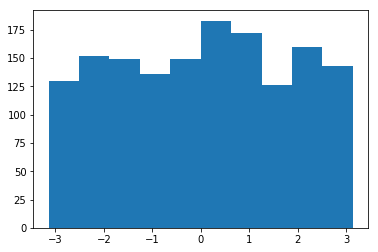

In [676]:
plt.hist(raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end])

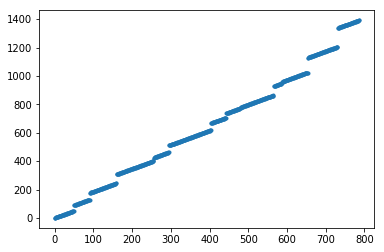

In [681]:
idx = np.where( np.logical_and( raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  > (-np.pi/2) ,
                                raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  < (np.pi/2) ) )[0]

plt.plot(idx, '.')

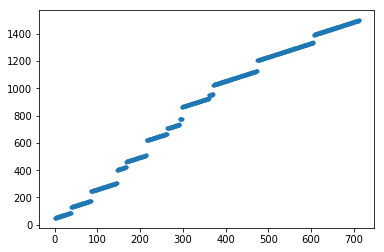

In [684]:
idx = np.where( np.logical_or( raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  < (-np.pi/2) ,
                                raw_out_theta[idx_trials[trial]:idx_trials[trial]+trial_end]  > (np.pi/2) ) )[0]

plt.plot(idx,'.')